# ComTel -  Identifying customer groups with clustering
by Giancarlo Marchesi

This case uses Peru's ERESTEL survey of telecom providers to identify business opportunities for the second major mobile carrier.

Peru is a middle income country, with a poverty level in the low 20s and extreme poverty of around 9%. The preferred mobile contract is the prepaid service (around 60% of active users). Users pay in increments of 5 o 10 soles (S/.) to use their phones for a week or 10 days. Carriers terminate the contract when the line hasn't been used for six months continuously. It is a common practice to switch carriers by just buying a new SIM card. On average, during the last year the market has lost around 2 million prepaid lines a year, yet activations are still net positive because of new users and SIM switching. 

The postpaid plans (paid at the end of the month) are two-fold. The control plan is a fixed-amount billed at the end of the month. If the user runs out of minutes or data according to their contract, it can add more in increments, similar to the prepaid plan. The postpaid plan (classic) is just open to bill whatever you consume. The contract has a fixed set of minutes and GB of data. Any use above that is billed automatically at the contract rate. The Peruvian market has migrated aggressively from
postpaid to control in the last five years (when the latter appeared as an option). Now 35% of contracts are control and 5% are prepaid. 

The case proposes a methodology to identify prepaid customers that are more likely to migrate to postpaid plans for a new campaign. I will use kmeans and agglomerative clustering. The dataset has identified the carriers for each observation, so it allows us to focus explicitely on the company's clients. 

Future analysis could identify which clients from other providers could migrate at any given contract type. The analysis of the market was done previously and can be found at https://github.com/gmarchesiv/Telecom_analytics 

In [562]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Data Wrangling

In [563]:
df = pd.read_stata('individuals.dta', convert_categoricals=False)

In [564]:
df.head()

,tipo,ficha_st,cod_per_st,q1,q3,q4,q5,q6,q7,q8,...,depa,prov,dist,ccpp,dep_est,estrato,conglo,area,n_personas,fact_exp
0,1.0,00001,01,1.0,1.0,1.0,61.0,1.0,1.0,2.0,...,1,101,010101,0101010001,1.0,3.0,1.0,1.0,1.0,179.013036
1,1.0,00002,01,2.0,1.0,1.0,58.0,1.0,1.0,2.0,...,1,101,010101,0101010001,1.0,3.0,1.0,1.0,2.0,122.725739
2,1.0,00002,02,2.0,2.0,2.0,57.0,1.0,1.0,2.0,...,1,101,010101,0101010001,1.0,3.0,1.0,1.0,2.0,122.725739
3,1.0,00003,01,2.0,1.0,1.0,62.0,1.0,1.0,2.0,...,1,101,010101,0101010001,1.0,3.0,1.0,1.0,2.0,122.725739
4,1.0,00003,02,2.0,2.0,2.0,59.0,1.0,1.0,2.0,...,1,101,010101,0101010001,1.0,3.0,1.0,1.0,2.0,122.725739


In [565]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47380 entries, 0 to 47379
Columns: 475 entries, tipo to fact_exp
dtypes: float32(8), float64(461), int16(1), int8(1), object(4)
memory usage: 170.0+ MB


In [566]:
df.shape

(47380, 475)

The database is pretty big, with 475 questions and 47380 respondents. 

The questions are number coded. I have analyzed the detailed questionaire and variable coding externally. The best course of action is to keep a manageable data set (aprox 25 columns). I will identify them, create a new dataframe and change the names of the columns for easier manipulation and understanding.   

In [567]:
 df2=df.iloc[:,[4,5,6,9,12,26,27,29,31,53,67,81,83,111,114,118,161,162,189,452,453,454,462,467]]

In [568]:
## The new dataframe
df2.head()

,q3,q4,q5,q8,q10,v1,v2,v3,v5,v9,...,v14b_1,v15,v17,v18,v28,nse,pobreza,empleo,ingreso_mensual,dist
0,1.0,1.0,61.0,2.0,3.0,1.0,1.0,5.0,2.0,3.0,...,13.0,2.0,3.0,5.0,2.0,4.0,3.0,1.0,500.000000,010101
1,1.0,1.0,58.0,2.0,1.0,1.0,1.0,5.0,2.0,3.0,...,7.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,2500.000000,010101
2,2.0,2.0,57.0,2.0,1.0,1.0,1.0,5.0,2.0,1.0,...,3.0,2.0,2.0,2.0,2.0,3.0,3.0,1.0,2500.000000,010101
3,1.0,1.0,62.0,2.0,2.0,1.0,2.0,5.0,2.0,3.0,...,3.0,2.0,5.0,5.0,2.0,4.0,3.0,1.0,266.666667,010101
4,2.0,2.0,59.0,2.0,2.0,1.0,1.0,5.0,2.0,3.0,...,7.0,2.0,4.0,5.0,2.0,4.0,3.0,2.0,NaN,010101


### Renaming variables 

In order to make the database easier to manipulate, columns need labels in English. 

In [569]:
df2=df2.rename(columns={
'q3':'house_head',
'q4':'gender',
'q5':'age', 
'q8':'student',
'q10':'marriage_status', 
'v1':'own_phone',
'v2':'smart_phone',
'v3':'since_when', 
'v5':'more_SIM',
'v9':'contract',
'v10b':'recharge',
'v11_1':'month_exp',
'v11b':'morethan_exp',
'v14':'carrier',
'v14b_1':'why_carrier',
'v15':'think_switch',
'v17':'research_comp',
'v18':'switch_ease',
'v28':'pay_more',
'nse':'nse',
'pobreza':'poverty',
'empleo':'employed',
'ingreso_mensual':'month_income',
'dist':'district',
})

In [570]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47380 entries, 0 to 47379
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   house_head       47380 non-null  float64
 1   gender           47346 non-null  float64
 2   age              47346 non-null  float64
 3   student          43609 non-null  float64
 4   marriage_status  38090 non-null  float64
 5   own_phone        38090 non-null  float64
 6   smart_phone      30380 non-null  float64
 7   since_when       30380 non-null  float64
 8   more_SIM         30380 non-null  float64
 9   contract         30380 non-null  float64
 10  recharge         19284 non-null  float64
 11  month_exp        30380 non-null  float64
 12  morethan_exp     30380 non-null  float32
 13  carrier          30380 non-null  float64
 14  why_carrier      27999 non-null  float64
 15  think_switch     27999 non-null  float64
 16  research_comp    27999 non-null  float64
 17  switch_ease 

I will explain the meaning of each as I analyze them individually. 

### Fill Nan with zero

The survey, conveniently, does not use 0 as a value for response. All binary variables are 1s and 2s, and categorical variables are floats starting at 1.  I'll fill out all NaNs with zeros so I can easily tabulate and graph them. 

In [571]:
df2.fillna(0, inplace=True)

In [572]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47380 entries, 0 to 47379
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   house_head       47380 non-null  float64
 1   gender           47380 non-null  float64
 2   age              47380 non-null  float64
 3   student          47380 non-null  float64
 4   marriage_status  47380 non-null  float64
 5   own_phone        47380 non-null  float64
 6   smart_phone      47380 non-null  float64
 7   since_when       47380 non-null  float64
 8   more_SIM         47380 non-null  float64
 9   contract         47380 non-null  float64
 10  recharge         47380 non-null  float64
 11  month_exp        47380 non-null  float64
 12  morethan_exp     47380 non-null  float32
 13  carrier          47380 non-null  float64
 14  why_carrier      47380 non-null  float64
 15  think_switch     47380 non-null  float64
 16  research_comp    47380 non-null  float64
 17  switch_ease 

### Exploratory data analysys

Let's analyze how representative the data base is of the total market. Remember, there is another repository with the market analysis in my Github site. 

#### Househead

In [420]:
df2.house_head.value_counts()

3.0     18170
1.0     15493
2.0      8968
5.0      1608
7.0      1591
6.0       988
4.0       380
10.0      148
9.0        22
8.0        12
Name: house_head, dtype: int64

1 represents the head of household. Other numbers are the relation to the heado of household. A more convenient numbering would be 1 for head and 2 for not. 

In [573]:
## a quick replacement to change q3 from member of household to just head of household or not
df2.loc[df2['house_head'] > 1, 'house_head'] = 2

In [574]:
## There are 15493 head of households in the survey
df2.house_head.value_counts()

2.0    31887
1.0    15493
Name: house_head, dtype: int64

*15493 respondents are heads of household.*

#### Gender

In [575]:
gender=df2.gender.value_counts()

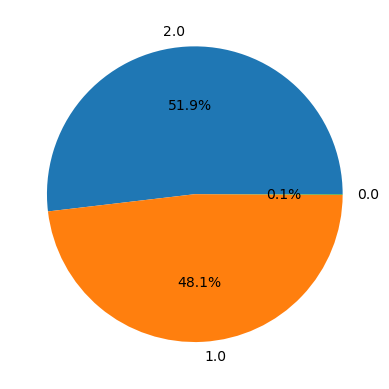

In [577]:
plt.pie(x=gender.values, labels=gender.index, autopct='%1.1f%%')
plt.show()

*There are slightly more women than men. The Peruvian population is closer to 49.5/50.5. The zeros are so small, we'll leave them for now as we'll  be dropping a few observations along the way. Let's get rid of the zeros.

In [579]:
pd.crosstab(df2.house_head, df2.gender, margins=True, margins_name="Total")

gender,0.0,1.0,2.0,Total
house_head,,,,
1.0,0,10373,5120,15493
2.0,34,12401,19452,31887
Total,34,22774,24572,47380


These zeros are not head of households. I will assign them to gender 2, women. 

In [580]:
df2.loc[(df2['gender'] ==0.0), 'gender' ] = 2.0

In [582]:
df2.gender.value_counts()

2.0    24606
1.0    22774
Name: gender, dtype: int64

#### Age

In [426]:
df2.age.describe()

count    47380.000000
mean        33.410827
std         21.129690
min          0.000000
25%         15.000000
50%         32.000000
75%         49.000000
max        108.000000
Name: age, dtype: float64

The age variable has no missing values. 25 percent or more of the distribution are children. That doesn't make sense for what we want to test. Lets cross this with own_phone.

#### Own_phone

In [583]:
## 1s are yes, 2s are no.  
df2.own_phone.value_counts()

1.0    30380
0.0     9290
2.0     7710
Name: own_phone, dtype: int64

In [584]:
df2[df2['age']<=15].own_phone.value_counts()

0.0    9290
2.0    1563
1.0    1390
Name: own_phone, dtype: int64

Empty values of own phone are entirely children. We can drop all observations here, as phoneless children are not the focus of the analysis. 

In [585]:
phoneless = df2[df2['own_phone']==0].index
df2.drop(phoneless, inplace=True)

In [586]:
df2.own_phone.value_counts()

1.0    30380
2.0     7710
Name: own_phone, dtype: int64

We can also get rid of the other phoneless people altogether. The business question specifically is about migrating existing customers, i.e., people that own a mobile phone.  

In [587]:
phoneless2 = df2[df2['own_phone']==2].index
df2.drop(phoneless2, inplace=True)

In [588]:
df2.shape

(30380, 24)

The size of the working database is now 30380 rows. Lets see the age distribution of people who own a phone. 

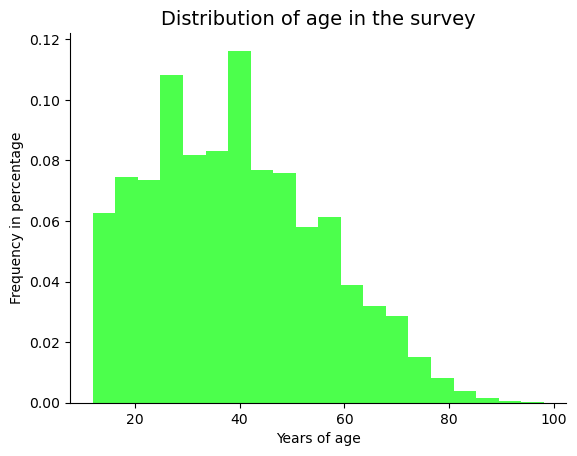

In [589]:
## Calculations and setting up the plot 
S= df2.age
plt.hist(S, bins=20, weights=np.ones_like(S) / len(S), color ='lime',alpha = 0.7)

## Titles
plt.title('Distribution of age in the survey', fontsize=14)
plt.xlabel('Years of age')
plt.ylabel('Frequency in percentage')

sns.despine()
plt.show()

In [590]:
df2.age.describe()

count    30380.000000
mean        39.359315
std         16.231431
min         12.000000
25%         26.000000
50%         38.000000
75%         50.000000
max         98.000000
Name: age, dtype: float64

*Some 12 year olds have cell phones, but the bottom quartile ends at 26, so it's reasonable. There probably is an insight in that first quartile. They are most likely dependents of wealthier families.* 

In [591]:
df2[df2['age']<=17].age.value_counts()

16.0    514
15.0    507
17.0    478
14.0    398
13.0    306
12.0    179
Name: age, dtype: int64

In [436]:
df2[df2['age']<=17].age.count()

2382

*Roughly 7% of those surveyed that have phones are minors. Let's do a crosstab with employed* 

In [593]:
pd.crosstab(df2[df2['age']<=17]['age'], df2[df2['age']<=17]['employed'], margins=True, margins_name="Total")

employed,0.0,1.0,2.0,Total
age,,,,
12.0,179,0,0,179
13.0,306,0,0,306
14.0,0,37,361,398
15.0,0,48,459,507
16.0,0,61,453,514
17.0,0,99,379,478
Total,485,245,1652,2382


Most of the children are dependents. But even so, the ones that do work do not have legal agency over signing a contract. Sin migration implies a contract, we are better of by getting rid of all minors. 

In [594]:
minors = df2[df2['age']<18].index
df2.drop(minors, inplace=True)

In [595]:
df2.shape

(27998, 24)

The database is down to 27998 clients. 

#### Student

In [596]:
df2.student.value_counts()

2.0    24810
1.0     3188
Name: student, dtype: int64

11% of those surveyed are currently students. These would be grad school, university or trade school students. 

#### Marriage status

In [597]:
df2.marriage_status.value_counts()

6.0    8491
1.0    8384
2.0    7755
5.0    2153
3.0    1025
4.0     190
Name: marriage_status, dtype: int64

1 is living with partner, 2 is married, 3 is widow, 4 is divorced, 5 is separated, 6 is single. We'll simplify this with 1 as currently hava a partner and 2 currently no partner. 

In [598]:
df2.loc[(df2['marriage_status'] == 2.0), 'marriage_status' ] = 1.0

In [599]:
df2.marriage_status.value_counts()

1.0    16139
6.0     8491
5.0     2153
3.0     1025
4.0      190
Name: marriage_status, dtype: int64

In [600]:
df2.loc[(df2['marriage_status'] > 2.0), 'marriage_status' ] = 2.0

In [601]:
df2.marriage_status.value_counts()

1.0    16139
2.0    11859
Name: marriage_status, dtype: int64

In [602]:
df2.rename(columns={'marriage_status': 'partner'}, inplace=True)

In [603]:
df2.partner.value_counts()

1.0    16139
2.0    11859
Name: partner, dtype: int64

57%  of those surveyed have a live-in partner. 

#### Smartphone

In [604]:
df2.smart_phone.value_counts()

1.0    24349
2.0     3519
3.0      130
Name: smart_phone, dtype: int64

3s are people that are not sure if they have a smartphone. This complicates the analysys unnecessarily. It's likely that if they don't know if it's a smartphone, it probably isn't, so we'll add them to 2. 

In [605]:
df2.loc[(df2['smart_phone'] == 3.0), 'smart_phone' ] = 2.0

In [606]:
df2.smart_phone.value_counts()

1.0    24349
2.0     3649
Name: smart_phone, dtype: int64

90% of users have a smartphone

#### Since when

In [607]:
df2.since_when.value_counts()

5.0    19652
4.0     3603
3.0     2999
2.0     1147
1.0      597
Name: since_when, dtype: int64

5 is more than 3 years, the rest are subdivisions of less than 3 years. Let's just split them in more and less than 3 years. 

In [608]:
df2.loc[(df2['since_when'] < 5.0), 'since_when' ] = 2.0

In [609]:
df2.since_when.value_counts()

5.0    19652
2.0     8346
Name: since_when, dtype: int64

In [610]:
df2.loc[(df2['since_when'] == 5.0), 'since_when' ] = 1.0

In [611]:
df2.since_when.value_counts()

1.0    19652
2.0     8346
Name: since_when, dtype: int64

Two thirds of users have had their phone for more than 3 years. 

#### More SIM

In [612]:
df2.more_SIM.value_counts()

2.0    26970
1.0     1028
Name: more_SIM, dtype: int64

Most people only have one SIM card

#### Contract

In [613]:
contract=df2.contract.value_counts()

In [614]:
contract

1.0    14300
3.0    10695
2.0     3003
Name: contract, dtype: int64

1 is prepaid, 2 is control and 3 is postpaid. Let's replace these values. This will be pretty useful through out the analysis. 

In [615]:
df2.loc[(df2['contract'] == 1.0), 'contract' ] = 'Prepaid'

In [616]:
df2.loc[(df2['contract'] == 2.0), 'contract' ] = 'Control'

In [617]:
df2.loc[(df2['contract'] == 3.0), 'contract' ] = 'Postpaid'

In [618]:
df2.contract.value_counts()

Prepaid     14300
Postpaid    10695
Control      3003
Name: contract, dtype: int64

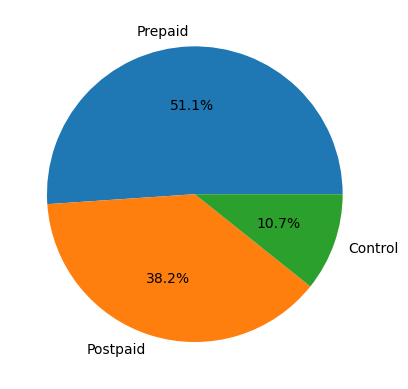

In [619]:
labels=['Prepaid', 'Postpaid', 'Control']
plt.pie(x=contract.values, labels=labels, autopct='%1.1f%%')
plt.show()

This is not representative of the market. In a previous analysis, I found that the 2021 market share is 60.9% prepaid, 3.5% post-paid and 35.6% control. However, remember that we took out the teenagers, which are dependents and are likely to get a prepaid phone from their parents. 

Furthermo, a control plan is a kind of postpaid plan. The survey is self reported so perhaps customers didn't have this nuance in consideration when responding. However, prepaids should be 60.9%, which means there is still a bias towards postpaid contracts.

Since we do not have a clear understanding of the dynamic between control and postpaid, I'll take the data at face value for the purpose of this case. 

#### Recharge

This number represents the number of times a prepaid or control line recharges during a given month. The more recharges, the likely it is to be paying the same as a postpaid line. 

In [620]:
df2.recharge.value_counts()

0.0    10695
3.0     5588
4.0     4969
1.0     3251
2.0     3007
5.0      386
6.0      102
Name: recharge, dtype: int64

In [621]:
pd.crosstab(df2.recharge, df2.contract, margins=True, margins_name="Total")

contract,Control,Postpaid,Prepaid,Total
recharge,,,,
0.0,0,10695,0,10695
1.0,2822,0,429,3251
2.0,32,0,2975,3007
3.0,55,0,5533,5588
4.0,76,0,4893,4969
5.0,6,0,380,386
6.0,12,0,90,102
Total,3003,10695,14300,27998


The zeros correspond to all postpaid lines. All recharges happen in control and prepaid plans. Almost all control plans recharge at least once a month and most prepaid lines recharge twice or more times. 

- The cheapest control in the market is 29 soles. 
- Five-day recharges cost 5 soles and last a week. 
- Ten-day recharges cost 10 soles. 3 recharges are basically the same as a control line. 
- The cheapest postpaid plan is 35 soles, so it is also in the vecinity of the cheapest control plan.

#### Monthly expenditure

In [463]:
df2.month_exp.describe() 

count    30380.000000
mean        30.310189
std         27.261561
min        -99.000000
25%         15.000000
50%         29.000000
75%         40.000000
max        340.000000
Name: month_exp, dtype: float64

There are some negative values that should not be there. The survey has assigned "no reponse" as a negative value of 99. This skews further calculations. I will replace these with the average of all observations with a expenditure above 0. 

In [622]:
df2[df2['month_exp']<0].month_exp.value_counts()

-99.0    203
Name: month_exp, dtype: int64

What type of contract do they belong to? 

In [623]:
pd.crosstab((df2[df2['month_exp']<0].month_exp),  df2.contract, margins=True, margins_name="Total")

contract,Control,Postpaid,Prepaid,Total
month_exp,,,,
-99.0,33,129,41,203
Total,33,129,41,203


They are distributed across the board, so let's just use the average. 

In [624]:
df2[df2['month_exp']>0].month_exp.mean()

32.514669958608664

In [625]:
df2.loc[(df2['month_exp'] < 0), 'month_exp' ] = 32.00

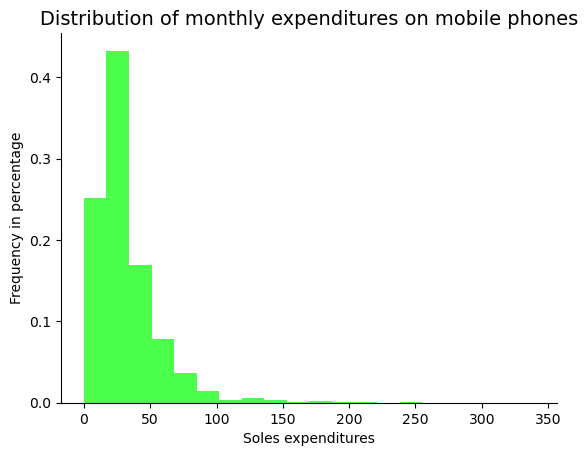

In [626]:
## Calculations and setting up the plot 
S= df2.month_exp
plt.hist(S, bins=20, weights=np.ones_like(S) / len(S), color ='lime',alpha = 0.7)

## Titles
plt.title('Distribution of monthly expenditures on mobile phones', fontsize=14)
plt.xlabel('Soles expenditures')
plt.ylabel('Frequency in percentage')

sns.despine()
plt.show()

In [627]:
df2.month_exp.describe()

count    27998.000000
mean        32.217124
std         24.957533
min          0.000000
25%         15.000000
50%         29.900000
75%         40.000000
max        340.000000
Name: month_exp, dtype: float64

In [628]:
## This will help visualize the distribution of monthly expenditures 
perc = [0.20, 0.4, 0.5, 0.6, 0.8, 1]
cat_columns = ['month_exp']

# Loop through each column...
for column in cat_columns:
    for p in perc:  
        i= df2[column].quantile(p) 
        _th=100*p
        print(f'The {_th} th quantile for {column} is {i} soles')
    print('\n')

The 20.0 th quantile for month_exp is 15.0 soles
The 40.0 th quantile for month_exp is 20.0 soles
The 50.0 th quantile for month_exp is 29.9 soles
The 60.0 th quantile for month_exp is 30.0 soles
The 80.0 th quantile for month_exp is 46.0 soles
The 100 th quantile for month_exp is 340.0 soles




The median expenditure is around the control plan. It make economic sense that 50% of the market should be postpaid. According to this survey, it's at 47%. So, at a minimum, 3% should be migrated to a control contract. However, Claro's economics might be a bit better, because it's one of the market incumbents.  Let's separate this continuous variable into a categorical one. 

In [631]:
df2['exp_cat']=4  ## more than 46. These are in line with post paid contracts

In [632]:
df2.loc[(df2['month_exp'] <= 15), 'exp_cat' ] = 1 ## these should all be prepaid contract 

In [633]:
df2.loc[(df2['month_exp'] > 15) & (df2['month_exp'] <= 30) , 'exp_cat' ] = 2 ## this is the cutoff for a Control plan

In [634]:
df2.loc[(df2['month_exp'] > 30) & (df2['month_exp'] <= 46) , 'exp_cat' ] = 3 ## this should be control and some prepaid

In [635]:
df2['exp_cat'].value_counts()

2    11709
1     7025
4     5594
3     3670
Name: exp_cat, dtype: int64

In [636]:
pd.crosstab(df2.exp_cat, df2.contract, margins=True, margins_name="Total")

contract,Control,Postpaid,Prepaid,Total
exp_cat,,,,
1,0,0,7025,7025
2,1415,3970,6324,11709
3,637,2400,633,3670
4,951,4325,318,5594
Total,3003,10695,14300,27998


- All the contracts in the first expenditure category are prepaid, as expected. 
- Most ot the contracts in the second expenditure category are also prepaid. There are some control and some post paid as well. This is probably where the self-reporting got confusing. Those postpaids are probably controls. 
- Exp cats 2, 3 and 4 have a good quantity of prepaid. This is where the targeting of the migration campaign should focus.

In [637]:
## This will help visualize the distribution of monthly expenditures 
contract=['Prepaid', 'Control', 'Postpaid']

for i in contract:
    x=df2[df2['contract']==i]['month_exp'].mean()
    print(f"The mean for contract {i} is {x}")

The mean for contract Prepaid is 18.013713286713287
The mean for contract Control is 42.656410256410254
The mean for contract Postpaid is 48.27692753623188


**What do the expenditure categories look like?** 

In [638]:
b=df2[df2['exp_cat']==1]['month_exp']

In [639]:
b

24        5.0
25       10.0
53       10.0
58        5.0
93        6.0
         ... 
47273    10.0
47370    15.0
47373    15.0
47377    15.0
47378    15.0
Name: month_exp, Length: 7025, dtype: float64

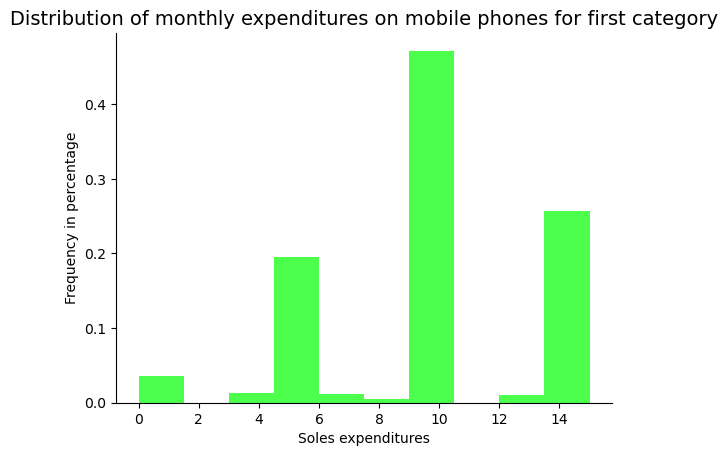

In [640]:
## Calculations and setting up the plot 
plt.hist(b, bins=10, weights=np.ones_like(b) / len(b), color ='lime',alpha = 0.7)

## Titles
plt.title('Distribution of monthly expenditures on mobile phones for first category', fontsize=14)
plt.xlabel('Soles expenditures')
plt.ylabel('Frequency in percentage')

sns.despine()
plt.show()

The first expenditure category looks sparse. Consumption seems to be sporadic. It will be hard to target these customers to migrate from prepaid to postpaid.   

In [642]:
c=df2[df2['exp_cat']==2]['month_exp']

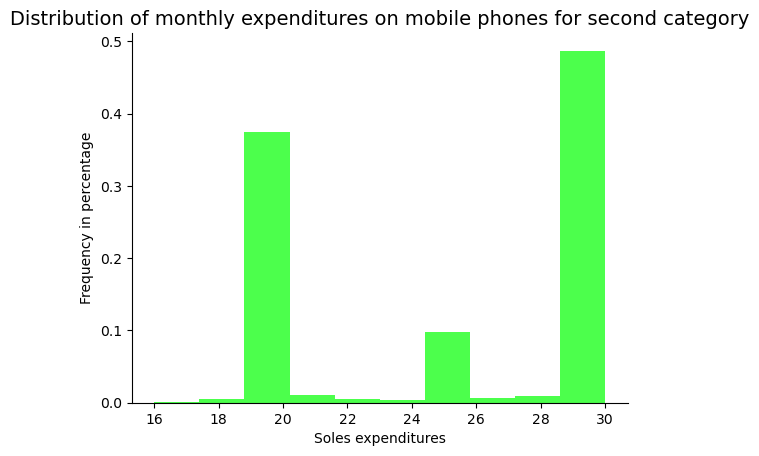

In [643]:
## Calculations and setting up the plot 
plt.hist(c, bins=10, weights=np.ones_like(c) / len(c), color ='lime',alpha = 0.7)

## Titles
plt.title('Distribution of monthly expenditures on mobile phones for second category', fontsize=14)
plt.xlabel('Soles expenditures')
plt.ylabel('Frequency in percentage')

sns.despine()
plt.show()

Here we see that nearly half customers spend the equivalent of the most affordable control plan. The prepaid customers of this segment are the primary targets, as are those in the third and fourth expenditure category. 

##### Recharge and expenditure category

In [644]:
pd.crosstab(df2.recharge, df2.exp_cat, margins=True, margins_name="Total")

exp_cat,1,2,3,4,Total
recharge,,,,,
0.0,0,3970,2400,4325,10695
1.0,279,1347,651,974,3251
2.0,2374,537,64,32,3007
3.0,3390,1998,137,63,5588
4.0,932,3606,312,119,4969
5.0,7,213,93,73,386
6.0,43,38,13,8,102
Total,7025,11709,3670,5594,27998


Of the frequent rechargers (2, 3 or 4 times a month), a sizeable portion are in the 2 and 3 expenditure bracket. These should be the main focus of the campaign. 

Also, minimal recharges are 5 soles for all carriers, so being in the first expenditure category and doing 4 or more recharges is not consistent.These customers are probably primed to move to a control plan. They just don't realize they are spending about as much (29 soles) a month by rechaging 10 soles 3 times a month. Let's see how the clustering sorts this. 

#### Carrier

In [645]:
df2['carrier'].value_counts()

1.0    9570
2.0    9277
4.0    4684
3.0    4440
5.0      27
Name: carrier, dtype: int64

- 1: Movistar
- 2: Claro
- 3: Entel
- 4: Bitel
- 5: Other

In [646]:
x=df2.carrier.value_counts()

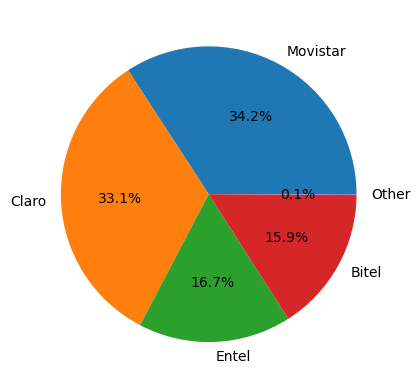

In [647]:
labels=['Movistar', 'Claro', 'Entel', 'Bitel', 'Other']
plt.pie(x, labels=labels, autopct='%1.1f%%')
plt.show()

According to latest OSIPTEL information has the following market share: 
- Movistar: 30.7%
- Claro: 28.4% 
- Entel: 21.3%
- Bietel: 19.3%
- Other: 0.4% 

So the sample is not perfectly representative of the market. 

##### Claro 

In [648]:
w=df2[df2['carrier']==2]['contract'].value_counts()

In [649]:
w

Prepaid     4798
Postpaid    3485
Control      994
Name: contract, dtype: int64

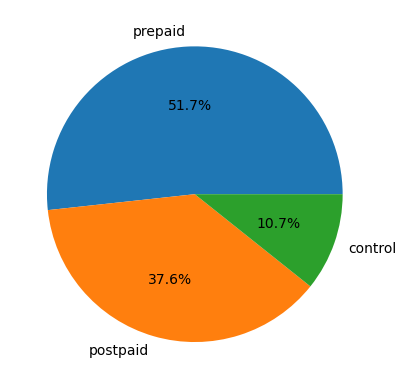

In [650]:
labels=['prepaid', 'postpaid', 'control']
plt.pie(w, labels=labels, autopct='%1.1f%%')
plt.show()

This looks very similar to the composition of the whole sample. However, according to the latest Osiptel data for 2021, in the case of Claro, prepaid should be 56.3%, control should be 39.6% and postpaid 4.0%. 

In [652]:
df2[df2['carrier']==2].groupby('contract')['month_exp'].mean()

contract
Control     46.059859
Postpaid    52.757042
Prepaid     17.625219
Name: month_exp, dtype: float64

Expenditures for the prepaid segment seem to fall in line with the market average. The other two are slightly higer. 

In [651]:
pd.crosstab(df2.exp_cat, df2[df2['carrier']==2]['contract'], margins=True, margins_name="Total")

contract,Control,Postpaid,Prepaid,Total
exp_cat,,,,
1,0,0,2408,2408
2,388,1041,2117,3546
3,208,671,172,1051
4,398,1773,101,2272
Total,994,3485,4798,9277


Looking at this, all prepaid contracts in the 3 and 4 expenditure category should be migrated as a first priority (272 contracts). The interesting part for the algorithm is to identify how many of the 2117 in the second category are similar to the postpaid or control customers so they can be targeted for a new contract. 

#### Why carrier

In [653]:
df2.why_carrier.value_counts()

7.0     7283
1.0     5062
2.0     4493
3.0     3442
5.0     2064
4.0     1614
9.0     1430
6.0      540
13.0     496
12.0     472
11.0     466
8.0      382
10.0     164
14.0      89
0.0        1
Name: why_carrier, dtype: int64

The survey gives the respondent too many choices and some are basically the same thing. For terms of the analysis, grouping would be more convenient. I will use the survey key (in Spanish) to group them in five categories and assign a new variable number in the twenties so it doesn't get mixed with the responses.   

- Category 1: Recommendation: 21 - 2, 13
- Category 2: Better price: 22   - 3, 5, 6
- Category 3: Better service: 23  - 4, 7, 8, 9, 10
- Category 4: Brand reputation: 24 - 1, 11
- Category 5: All other: 25: 12, 14, 0

In [654]:
df2.loc[(df2['why_carrier'] == 2.0) | (df2['why_carrier'] == 13.0) , 'why_carrier' ] = 21.0

In [655]:
df2.loc[(df2['why_carrier'] == 3.0) | (df2['why_carrier'] == 5.0) | (df2['why_carrier'] == 6.0), 'why_carrier' ] = 22.0

In [656]:
df2.loc[(df2['why_carrier'] == 4.0) | (df2['why_carrier'] == 7.0) | (df2['why_carrier'] == 8.0) | (df2['why_carrier'] == 9.0) | (df2['why_carrier'] == 10.0), 'why_carrier' ] = 23.0

In [657]:
df2.loc[(df2['why_carrier'] == 1.0) | (df2['why_carrier'] == 11.0), 'why_carrier' ] = 24.0

In [658]:
df2.loc[(df2['why_carrier'] == 12.0) | (df2['why_carrier'] == 14.0) | (df2['why_carrier'] == 0.0), 'why_carrier' ] = 25.0

In [659]:
df2.why_carrier.value_counts()

23.0    10873
22.0     6046
24.0     5528
21.0     4989
25.0      562
Name: why_carrier, dtype: int64

Better service is considered the top category, then price, then reputation, then recommendation and finally, all others

#### Think of switching carriers

In [660]:
df2.think_switch.value_counts()

2.0    25810
1.0     2187
0.0        1
Name: think_switch, dtype: int64

Few people have thought of switching carriers. This probably won't matter much for the business question. I think we can drop this variable. 

In [661]:
df2.drop(columns=['think_switch'], inplace=True)

#### Research the competition to change plans

The question is how frequently the person researches the competition to switch carriers, on a scale from 1 to 7 by intensity. 99 is the don't know answer, which is likely to actually be just a 1, as in never. 1 is also the most frequent answer. 

In [662]:
df2.research_comp.value_counts()

 1.0     8524
 2.0     5604
 3.0     4169
 4.0     3314
 5.0     3196
-99.0    2013
 6.0      734
 7.0      443
 0.0        1
Name: research_comp, dtype: int64

In [663]:
df2.loc[(df2['research_comp'] == -99.0), 'research_comp' ] = 1.0

In [664]:
df2.research_comp.value_counts()

1.0    10537
2.0     5604
3.0     4169
4.0     3314
5.0     3196
6.0      734
7.0      443
0.0        1
Name: research_comp, dtype: int64

In [665]:
df2.research_comp.mean()

2.535645403243089

For the missing values, I'll asign the median value of 2. 

In [666]:
df2.loc[(df2['research_comp'] == 0.0), 'research_comp' ] = 3.0

#### Switch ease

The question is how easy is the process to switch carriers, on a scale from 1 to 7 by intensity. 99 is the don't know answer, which is likely to actually be just a 1, as in never. 

In [667]:
df2.switch_ease.value_counts()

 5.0     5202
 4.0     4772
 3.0     4464
 1.0     4265
 2.0     3641
-99.0    3095
 6.0     1579
 7.0      979
 0.0        1
Name: switch_ease, dtype: int64

In this case, the most popular answer is 5, that is more than somewhat complicated to switch companies. 4 is the second most fequent answer and 3 the third. Hence in this case, people do not think it is the simplest of procedures. It's reasonable to suppos that People that gave a non-answer (-99) probably haven't tried it because they at leas believe it is sowewhat difficult. Hence, we will give them the 3 score.  We'll give the zeros the median value

In [668]:
df2.loc[(df2['switch_ease'] == -99.0), 'switch_ease' ] = 3.0

In [669]:
df2.switch_ease.median()

3.0

In [670]:
df2.loc[(df2['switch_ease'] == 0.0), 'switch_ease' ] = 3.0

In [671]:
df2.switch_ease.value_counts()

3.0    7560
5.0    5202
4.0    4772
1.0    4265
2.0    3641
6.0    1579
7.0     979
Name: switch_ease, dtype: int64

#### Did I pay more than I wanted last month?

In [672]:
df2.pay_more.value_counts()

2.0    27047
1.0      950
0.0        1
Name: pay_more, dtype: int64

2 is a no. Most people paid what they wanted to this month. This is likely a relevant variable. Let's assign the 0 a 1. 

In [673]:
df2.loc[(df2['pay_more'] == 0.0), 'pay_more' ] = 1.0

#### NSE

NSE is the socioeconomic level, going from richest to poorest 1 to 5. There are very few people at the top. Let's crosstab this with expenditure. 

In [674]:
df2.nse.value_counts()

3.0    9778
4.0    9138
5.0    6373
2.0    2496
1.0     213
Name: nse, dtype: int64

In [675]:
pd.crosstab(df2.exp_cat, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
exp_cat,,,,,,
1,8,235,1635,2486,2661,7025
2,31,673,3912,4248,2845,11709
3,32,440,1610,1096,492,3670
4,142,1148,2621,1308,375,5594
Total,213,2496,9778,9138,6373,27998


NSEs 2, 3 and 4 are "middle class". 5 is close or below the poverty line. The lion's share of contracts in expenditure categories 2 and 3 are in the middle class. 

In [676]:
pd.crosstab(df2.contract, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
contract,,,,,,
Control,64,465,1328,832,314,3003
Postpaid,129,1542,4754,3056,1214,10695
Prepaid,20,489,3696,5250,4845,14300
Total,213,2496,9778,9138,6373,27998


Lets look at the type of contract prevalent in the middle class. 

In [677]:
z=df2[(df2['nse']==2) | (df2['nse']==3) |(df2['nse']==4)]['contract'].value_counts()

In [678]:
z

Prepaid     9435
Postpaid    9352
Control     2625
Name: contract, dtype: int64

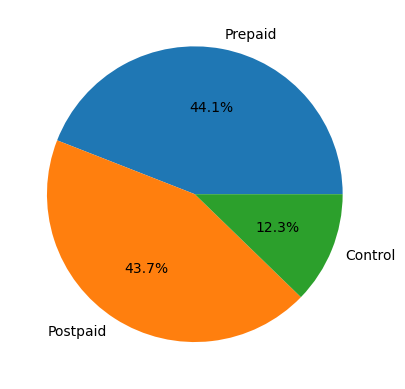

In [679]:
plt.pie(z.values, labels=z.index, autopct='%1.1f%%')
plt.show()

Postpaid+control lines are more prevalent than prepaid lines in the middle class. 

#### Poverty

Describes if the person is below the national poverty level. 

In [680]:
df2.poverty.value_counts()

3.0    21524
2.0     4759
1.0     1715
Name: poverty, dtype: int64

1 is extreme poverty, 2 is poverty and 3 is no poverty. 

In [681]:
pd.crosstab(df2.poverty, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
poverty,,,,,,
1.0,0,11,125,419,1160,1715
2.0,11,80,926,1865,1877,4759
3.0,202,2405,8727,6854,3336,21524
Total,213,2496,9778,9138,6373,27998


There are some mistakes here that could affect the clustering. 
- No one in sector 1 (NSE A) is poor. By definition, they make more than 3000 dollars a month. 
- There are also no extreme poverty (1) in sectors 2 and 3. There is a little noise in this variable. The numbers are small, which probably points to a misclassification or error in tabulation. We can clean this up easily. 

In [682]:
## Taking out the poor from the top NSE
df2.loc[(df2['nse'] == 1.0) & (df2['poverty'] == 2.0), 'poverty' ] = 3.0

In [683]:
pd.crosstab(df2.poverty, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
poverty,,,,,,
1.0,0,11,125,419,1160,1715
2.0,0,80,926,1865,1877,4748
3.0,213,2405,8727,6854,3336,21535
Total,213,2496,9778,9138,6373,27998


In [684]:
## Taking out the extreme poor from NSEs 2 & 3 and migrating then to poor 
df2.loc[(df2['nse'] == 2.0) & (df2['poverty'] == 1.0), 'poverty' ] = 2.0

In [686]:
pd.crosstab(df2.poverty, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
poverty,,,,,,
1.0,0,0,125,419,1160,1704
2.0,0,91,926,1865,1877,4759
3.0,213,2405,8727,6854,3336,21535
Total,213,2496,9778,9138,6373,27998


In [687]:
df2.loc[(df2['nse'] == 3.0) & (df2['poverty'] == 1.0), 'poverty' ] = 2.0

In [688]:
pd.crosstab(df2.poverty, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
poverty,,,,,,
1.0,0,0,0,419,1160,1579
2.0,0,91,1051,1865,1877,4884
3.0,213,2405,8727,6854,3336,21535
Total,213,2496,9778,9138,6373,27998


#### Employed

In [689]:
df2.employed.value_counts()

1.0    19451
2.0     8547
Name: employed, dtype: int64

Most people are employed. let's look at the age of the missing values. 

#### Monthly income

In [690]:
df2.month_income.describe()

count    27998.000000
mean      1262.319492
std       1333.079014
min          0.000000
25%        100.000000
50%       1000.000000
75%       1910.833333
max      20000.000000
Name: month_income, dtype: float64

In [691]:
## This will help visualize the distribution of monthly expenditures 
perc = [0.20, 0.4, 0.5, 0.6, 0.8, 1]
cat_columns = ['month_income']

# Loop through each column...
for column in cat_columns:
    for p in perc:  
        i= df2[column].quantile(p) 
        _th=100*p
        print(f'The {_th} th quantile for {column} is {i} soles')
    print('\n')

The 20.0 th quantile for month_income is 0.0 soles
The 40.0 th quantile for month_income is 800.0 soles
The 50.0 th quantile for month_income is 1000.0 soles
The 60.0 th quantile for month_income is 1302.5 soles
The 80.0 th quantile for month_income is 2000.0 soles
The 100 th quantile for month_income is 20000.0 soles




*Let's create an income category to simplify things for the classifier.*

In [692]:
df2['income_cat']=1.0

In [693]:
df2.loc[(df2['month_income'] > 0) & (df2['month_income'] < 1000) , 'income_cat' ] = 2.0

In [694]:
df2.loc[(df2['month_income'] >= 1000) & (df2['month_income'] < 2000) , 'income_cat' ] = 3.0

In [695]:
df2.loc[(df2['month_income'] >= 2000), 'income_cat' ] = 4.0

In [696]:
df2.income_cat.value_counts()

3.0    7646
2.0    7275
4.0    6871
1.0    6206
Name: income_cat, dtype: int64

In [697]:
pd.crosstab(df2.income_cat, df2.nse, margins=True, margins_name="Total")

nse,1.0,2.0,3.0,4.0,5.0,Total
income_cat,,,,,,
1.0,40,531,2162,2138,1335,6206
2.0,12,229,1736,2546,2752,7275
3.0,20,496,2727,2762,1641,7646
4.0,141,1240,3153,1692,645,6871
Total,213,2496,9778,9138,6373,27998


#### District

In [551]:
df2.district.value_counts()

150132    918
130101    738
211101    541
150103    463
140101    420
         ... 
200404     19
160501     16
250302     12
160506     10
200302      6
Name: district, Length: 321, dtype: int64

This is the geolocalization tracker code used in Peru. The first to digits are state, the next two province, and the last two district. 

In [552]:
df2.district.nunique()

321

321 of 1890 districts are represented in the survey. It's a variable that can be used for mapping, but it's not a numerical value. Aside from this, all others can be used for clustering. 

In [553]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30380 entries, 0 to 47378
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_head     30380 non-null  float64
 1   gender         30380 non-null  float64
 2   age            30380 non-null  float64
 3   student        30380 non-null  float64
 4   partner        30380 non-null  float64
 5   own_phone      30380 non-null  float64
 6   smart_phone    30380 non-null  float64
 7   since_when     30380 non-null  float64
 8   more_SIM       30380 non-null  float64
 9   contract       30380 non-null  object 
 10  recharge       30380 non-null  float64
 11  month_exp      30380 non-null  float64
 12  morethan_exp   30380 non-null  float32
 13  carrier        30380 non-null  float64
 14  why_carrier    30380 non-null  float64
 15  research_comp  30380 non-null  float64
 16  switch_ease    30380 non-null  float64
 17  pay_more       30380 non-null  float64
 18  nse   

We can drop it for now, because we won't use a map at this point. 

In [699]:
df2.drop(columns=['district'], inplace=True)

In [700]:
df2.columns

Index(['house_head', 'gender', 'age', 'student', 'partner', 'own_phone',
       'smart_phone', 'since_when', 'more_SIM', 'contract', 'recharge',
       'month_exp', 'morethan_exp', 'carrier', 'why_carrier', 'research_comp',
       'switch_ease', 'pay_more', 'nse', 'poverty', 'employed', 'month_income',
       'exp_cat', 'income_cat'],
      dtype='object')

## Clustering analysis

### Find similar Claro clients that can migrate from prepaid to postpaid

In this part of the analysis, I want to determine which prepaid clients cluster with postpaid and control programs to offer them a new contract. For this: 
- I will keep only Claro customers 
- Take out the `contract` variable. We'll evaluate after clustering. 
- Conduct the clustering analysis
- Contrast the results with the `contract` column

In [701]:
df3=df2[df2['carrier']==2]

In [702]:
df3.shape

(9277, 24)

In [703]:
df4=df3.drop(columns=['contract'])

In [704]:
df4.shape

(9277, 23)

#### Visualizing using PCA 

Principal component analysis can identify the first few "most important" components, which show the most variance within the data. These will be useful viewing angles for determining how many clusters are suitable for this dataset.

In [705]:
# We'll need to scale the data first
from sklearn.preprocessing import StandardScaler

# Create scaler object
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df4)

In [706]:
## Now, applying PCA
from sklearn.decomposition import PCA

# create our PCA object, we'll look at the first 4principal components
my_pca = PCA(n_components=6)

# transform our scaled data
pc_data = my_pca.fit_transform(scaled_data)

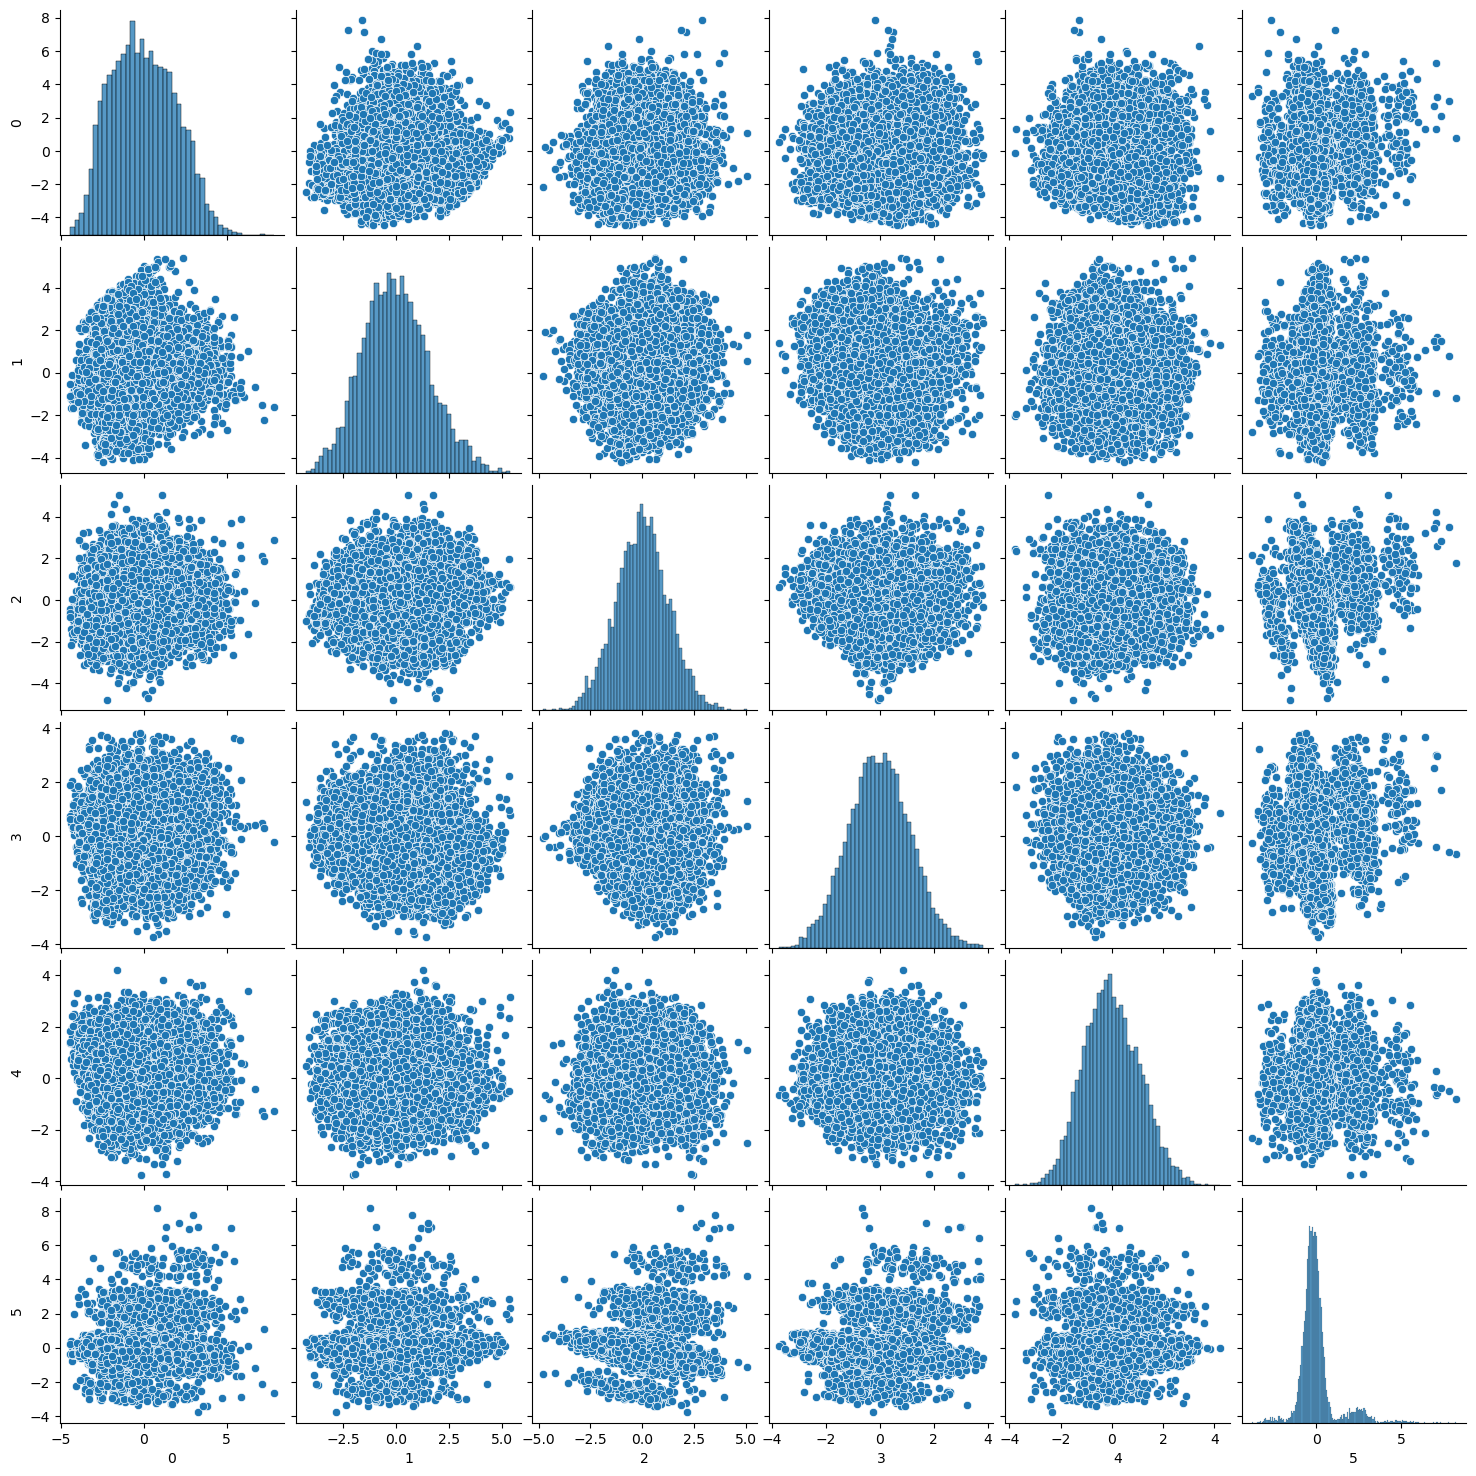

In [707]:
## Now let's visualize the scatterplot using PCA data
sns.pairplot(pd.DataFrame(pc_data));

There are hints of 4 clusters visible in the PCA, especially in PCA 2. 

#### Visualizing with t-SNE

This is a technique for visualizing high-dimensional data in 2D while preserving much of the high-dimensional structure. We choose two components to visualize in 2D. 

In [708]:
from sklearn.manifold import TSNE

my_tsne = TSNE(n_components=2) 
tsne_data = my_tsne.fit_transform(scaled_data)

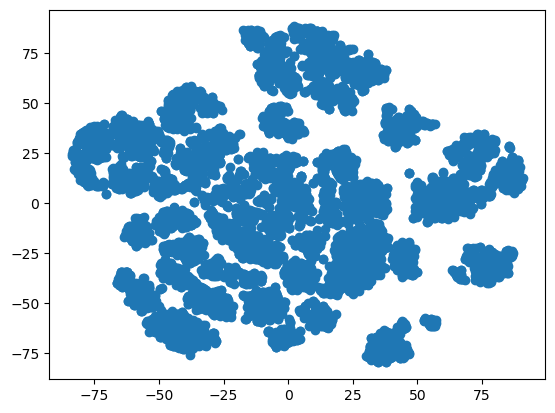

In [709]:
plt.figure()
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

The figure is pointing at the existence of various clusters. Maybe six or more. 

#### Clustering analysis

##### K-Means

In [710]:
from sklearn.cluster import KMeans

# define number of clusters to try out: 
# 10 is enough for the size of this dataset
# I will plot intertia in the next graph
k_values = range(1, 11)
inertia_list = []

for k in k_values:
    
    # instantiate a kmeans clusterer
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_data)
    
    # calculate the Inertia score and append to list
    inertia_list.append(kmeans.inertia_)

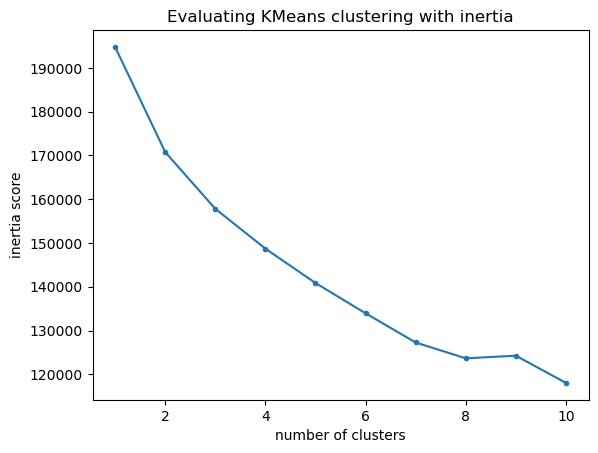

In [711]:
# Visualize the skree plot (elbow plot)
plt.figure()
plt.plot(k_values, inertia_list, marker='.')
plt.xlabel('number of clusters')
plt.ylabel('inertia score')
plt.title('Evaluating KMeans clustering with inertia')
plt.show()

8 seems to be the point of inflextion in the elbow of the skree plot. Let's check the silhoutte score. 

In [712]:
from sklearn.metrics import silhouette_score

k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    
    # instantiate a kmeans clusterer
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(scaled_data)
    
    # calculate the Silhouette score and append to list
    cluster_labels = kmeans.labels_
    silhouette = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette)

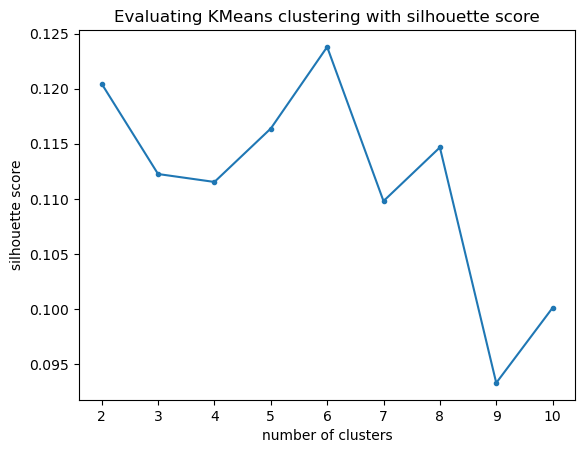

In [713]:
# Visualize the results
plt.figure()
plt.plot(k_values, silhouette_scores, marker='.')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Evaluating KMeans clustering with silhouette score')
plt.show()

6 maximizes the silhoutte score.

##### Agglomerative clustering

In [714]:
from sklearn.cluster import AgglomerativeClustering

k_values = range(2,11)
silhouette_scores = []

for k in k_values:
    
    # instantiate and fit our agglomerative clusterer
    aggclust = AgglomerativeClustering(n_clusters = k)
    aggclust.fit(scaled_data)
    
    # get cluster labels and calculate the silhouette score
    cluster_labels = aggclust.labels_
    silhouette = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette)

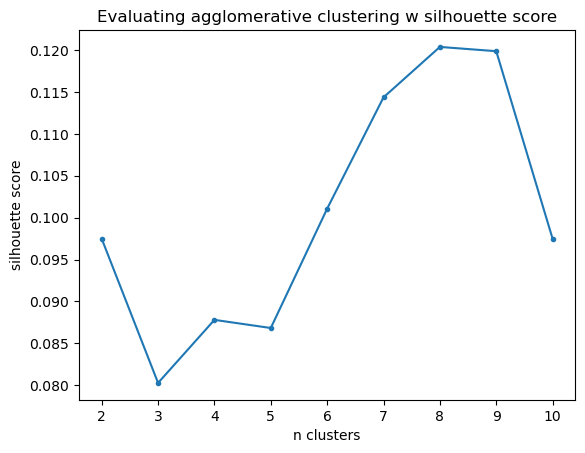

In [715]:
plt.figure()
plt.plot(k_values, silhouette_scores, marker='.')
plt.xlabel('n clusters')
plt.ylabel('silhouette score')
plt.title('Evaluating agglomerative clustering w silhouette score')
plt.show()

In this case the best silhoutte score is 8. 

#### Including the results in the dataframe

Let's re-fit two clustering models with the best silhoutte score and add the cluster label as a column in our original dataset for further visualization and analysis. 

##### Kmeans with n=6

In [716]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(scaled_data)

df4['kmeans_label'] = kmeans.labels_

Now, lets add the contract column again

In [717]:
df4['contract']=df3['contract']

In [718]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9277 entries, 0 to 47378
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   house_head     9277 non-null   float64
 1   gender         9277 non-null   float64
 2   age            9277 non-null   float64
 3   student        9277 non-null   float64
 4   partner        9277 non-null   float64
 5   own_phone      9277 non-null   float64
 6   smart_phone    9277 non-null   float64
 7   since_when     9277 non-null   float64
 8   more_SIM       9277 non-null   float64
 9   recharge       9277 non-null   float64
 10  month_exp      9277 non-null   float64
 11  morethan_exp   9277 non-null   float32
 12  carrier        9277 non-null   float64
 13  why_carrier    9277 non-null   float64
 14  research_comp  9277 non-null   float64
 15  switch_ease    9277 non-null   float64
 16  pay_more       9277 non-null   float64
 17  nse            9277 non-null   float64
 18  poverty

*What are we looking for?* The mostly-postpaid clusters that have pockets of prepaid customers. Their grouping should make the latter more likely to migrate and become the former.* 

In [719]:
pd.crosstab(df4.contract, df4.kmeans_label, margins=True, margins_name="Total")

kmeans_label,0,1,2,3,4,5,Total
contract,,,,,,,
Control,19,174,38,199,538,26,994
Postpaid,69,291,159,666,2163,137,3485
Prepaid,1051,2186,137,1177,95,152,4798
Total,1139,2651,334,2042,2796,315,9277


- Cluster 0: It has a majority of prepaid and very few postpaid or control. Not a target.
- Cluster 1: it's mostly the prepaid cluster as well. Not a target. 
- **Cluster 2: Predominantly postpaid. Primed to migrate the prepaid. 137 likely migrators.**  
- **Cluster 3: mostly prepaid, but a sizeable contingent of postpaid. This is a target. 1177 potential migrators**
- **Cluster 4: Predominantly postpaid. Primed to migrate the prepaid. 95 likely migrators.
- **Cluster 5: equal amounts of prepaid and postpaid. 152 potential migrators**

Building a dataframe of potential migrators, keeping those 4 clusters and only prepaid. 

In [720]:
kmeansdf=df4[(df4['kmeans_label']==2) & (df4['contract']=='Prepaid') | (df4['kmeans_label']==3) & (df4['contract']=='Prepaid')  
           | (df4['kmeans_label']==4) & (df4['contract']=='Prepaid') | (df4['kmeans_label']==5) & (df4['contract']=='Prepaid')]

In [721]:
kmeansdf.shape

(1561, 25)

**There are potentially 1561 migrators. Let's check the results from agglomerative.** 

##### Agglomerative with n=8

In [722]:
aggclust = AgglomerativeClustering(n_clusters=8)
aggclust.fit(scaled_data)

df4['agg_label'] = aggclust.labels_

In [723]:
pd.crosstab(df4.contract, df4.agg_label, margins=True, margins_name="Total")

agg_label,0,1,2,3,4,5,6,7,Total
contract,,,,,,,,,
Control,116,101,175,502,18,38,26,18,994
Postpaid,241,318,556,1910,61,158,134,107,3485
Prepaid,1992,467,861,96,974,137,152,119,4798
Total,2349,886,1592,2508,1053,333,312,244,9277


- Cluster 0 is clearly the prepaid one. We can deprioritize this one. 
- **Cluster 1 is an even mix. 467 potential migrators** 
- **Cluster 2 also an even mix. 861 potential migrators** 
- **Cluster 3 is clearly a postpaid one. 96 likely migrators**
- Cluster 4 is a prepaid one with no postpaid. Not a priority.  
- **Cluster 5, 6 and 7 are also an even mix.** 


Lets create a dataframe and then crosstab with income

In [726]:
aggdf=df4[(df4['agg_label'] ==1) & (df4['contract']=='Prepaid')| 
         (df4['agg_label'] ==2) & (df4['contract']=='Prepaid')|
         (df4['agg_label'] ==3) & (df4['contract']=='Prepaid')|
         (df4['agg_label'] ==5) & (df4['contract']=='Prepaid')| 
         (df4['agg_label'] ==6) & (df4['contract']=='Prepaid')|
         (df4['agg_label'] ==7) & (df4['contract']=='Prepaid')]

In [727]:
aggdf.shape

(1832, 26)

**Potentially, 1832 migrators**

##### Intersection of both methods

If we intersect both classifiers we might get more robustness. Both algorithms chose them. 

In [740]:
#which ones are in both groups? 
twomethod = pd.merge(kmeansdf, aggdf, left_index=True, right_index=True)

In [741]:
twomethod.shape

(1479, 51)

In [742]:
twomethod=twomethod.iloc[:, 0:25]

In [734]:
twomethod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1479 entries, 79 to 47336
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   house_head_x     1479 non-null   float64
 1   gender_x         1479 non-null   float64
 2   age_x            1479 non-null   float64
 3   student_x        1479 non-null   float64
 4   partner_x        1479 non-null   float64
 5   own_phone_x      1479 non-null   float64
 6   smart_phone_x    1479 non-null   float64
 7   since_when_x     1479 non-null   float64
 8   more_SIM_x       1479 non-null   float64
 9   recharge_x       1479 non-null   float64
 10  month_exp_x      1479 non-null   float64
 11  morethan_exp_x   1479 non-null   float32
 12  carrier_x        1479 non-null   float64
 13  why_carrier_x    1479 non-null   float64
 14  research_comp_x  1479 non-null   float64
 15  switch_ease_x    1479 non-null   float64
 16  pay_more_x       1479 non-null   float64
 17  nse_x       

**Result: 1479 possible migrators.** 

In [743]:
twomethod.index

Int64Index([   79,   271,   280,   324,   330,   338,   455,   464,   477,
              497,
            ...
            46638, 46721, 46728, 46739, 46951, 47001, 47041, 47134, 47331,
            47336],
           dtype='int64', length=1479)

**What does this final cluster look like?**

In [744]:
twomethod.income_cat_x.value_counts()

1.0    929
2.0    337
3.0    119
4.0     94
Name: income_cat_x, dtype: int64

63% of the possible migrators don't report any income. This however could be just underreporting income because of the informality in the economy. 

In [745]:
twomethod.exp_cat_x.value_counts()

1    726
2    631
3     64
4     58
Name: exp_cat_x, dtype: int64

50% are in expenditure category 1, but we know none of those actually spend close to what the minimum control plan is. 

In [746]:
twomethod.nse_x.value_counts()

4.0    546
3.0    475
5.0    380
2.0     73
1.0      5
Name: nse_x, dtype: int64

The clusters have done a decent job at filtering the socieconomic levels. People in the 5th level (E), as we saw at the beginning are overwhelmingly prepaid because of income. If we were to filter out any noise it would be with this variable. The previous two are self-reported and could be subject to bias, whereas the surveyor has phyisical evidence of the quality of the home where the interview took place to assess NSE. 

In [747]:
final=twomethod[twomethod['nse_x']<5]

In [748]:
final.shape

(1099, 25)

In [749]:
final.recharge_x.value_counts()

3.0    389
4.0    359
2.0    260
1.0     61
5.0     28
6.0      2
Name: recharge_x, dtype: int64

The final set is mostly composed of multiple rechargers. If we wanted to set an additional filter, we could set it at above 1. However, perhaps here it would be more appropriate to gather some field data by conducting an A/B test on the 1s and 2s recharges to see if they actually can be migrated. 

In [750]:
final.exp_cat_x.value_counts()

1    545
2    460
3     47
4     47
Name: exp_cat_x, dtype: int64

Half of the clients are still in expenditure category 1, which is below the minimum control plan. 

In [751]:
pd.crosstab(final.exp_cat_x, final.recharge_x, margins=True, margins_name="Total")

recharge_x,1.0,2.0,3.0,4.0,5.0,6.0,Total
exp_cat_x,,,,,,,
1,30,199,243,71,2,0,545
2,13,47,134,252,13,1,460
3,8,7,6,23,2,1,47
4,10,7,6,13,11,0,47
Total,61,260,389,359,28,2,1099


There is an inconsistency between expenditure category 1 (less than 15 soles) and having 3 or more recharges a month (the minimum recharge is 5 soles). 

## Conclusion 

I have used to different clustering algorithms to identify 1100 potential customers that could be migragted from a prepaid to a postpaid contract. The main hypothesis of this analysis is that identifying prepaid clients in predominantly postpaid clusters increases the chances of migrating such customers.  I kept the intersection of both algorithms to boost the probability of success.   

There are, however, certain caveats in the final set of clients. Half of them have reported that their last mobile phone expenditure is less than the cheapest control plan, yet there are inconsistencies when we add the number of reported monthly recharges. 

This is an example of how to use external data. In real life, the company would use their own data to on expenditure category, and number of recharges to cluster. It would be more effective and scalable. 

If we were to suppose that this was the only information available, we'd need to straighten out this inconsistency with an A/B test. Divide the group of 1 and 2 recharges in half at random. Give the first group the same sales speach as exp_categories 3 to 6. Make a special offer to the other half of the random group of 1 and 2 recharges, like the first 2 months are free. See if they are price sensitive. If both groups close at the same rate, then the self-reporting wasn't as precise, i.e. they probably recharge their phone more and pay around 30 soles a month. If the group with the discount offer closes faster, then, yes this is a price sensitive group and the offer will likely help close further migrations.   

